In [1]:
#importing libraries
from matplotlib import pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import cv2

In [2]:
#importing drive to access pictures
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


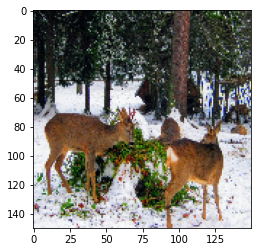

In [3]:
# preprocessing of images
# accessing image directory
for root, dirs, files in os.walk("/content/drive/MyDrive/image_classifier/image_classifier_data/exam_images"):
  path = root.split(os.sep)

# split head and tail 
  for file in files:
    _, extension = os.path.splitext(file)
    if extension == ".jpg":
      fullpath = "/".join(path) + "/" + file
      # print(fullpath)

      #load image
      current = cv2.imread(fullpath, cv2.IMREAD_COLOR)
      # convert color space
      converted = cv2.cvtColor(current, cv2.COLOR_BGR2RGB)
      # resize image
      converted = cv2.resize(converted, (150, 150))
      # display image
      plt.imshow(converted)

In [4]:
# look for corrupted images
# filter out images that do not have string "JFIF" in header (bitmap graphic that uses JPEG compression)

num_skipped = 0
# go inside directory
for root, dirs, files in os.walk("/content/drive/MyDrive/image_classifier/image_classifier_data/exam_images"):
  path = root.split(os.sep)
  for file in files:
    _, extension = os.path.splitext(file)
    if extension == ".jpg":
      filepath = root + "/" + file
      try:
        # opens file in binary format for reading
        fobj = open(filepath, "rb")
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
      finally:
        fobj.close()
      if not is_jfif:
        num_skipped += 1
        # Delete corrupted image
        os.remove(filepath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [5]:
# size of images closest to the size of the smallest images to train faster.
# if small images are increased in size, small image pixels are stretched and can obscure model’s ability to learn key features.
img_height = 150
img_width = 150

In [6]:
#loading images
images_path = "/content/drive/MyDrive/image_classifier/image_classifier_data/exam_images"
training_dataset = keras.preprocessing.image_dataset_from_directory(
  images_path,
  # generated from the directory structure
  labels='inferred',
  # encoded as a categorical vector for categorical_crossentropy loss function
  label_mode='categorical',
  color_mode="rgb",
  # batch size is a hyperparamater that estimates error gradient. Small batch sizes have been showed to achieve best performance; 1 to 32. 
  batch_size=64,
  image_size=(img_height, img_width),
  subset="training",
  # fraction used as validation data(not trained) 
  validation_split=0.1,
  # number used to initialize a pseudorandom number generator
  seed=1
)

test_dataset = keras.preprocessing.image_dataset_from_directory(
  images_path,
  labels='inferred',
  label_mode='categorical',
  color_mode="rgb",
  batch_size=64,
  image_size=(img_height, img_width),
  subset="validation",
  validation_split=0.1,
  seed=1
)

Found 1195 files belonging to 4 classes.
Using 1076 files for training.
Found 1195 files belonging to 4 classes.
Using 119 files for validation.


In [7]:
#defining classes
class_names= training_dataset.class_names
print(class_names)

['bicycles', 'cars', 'deer', 'mountains']


In [8]:
# defining model with all layers
model = keras.Sequential([
    #input layer
    keras.Input(shape=(img_height, img_width, 3)),
    # A kernel is a filter extracting features from images. Limiting number of parameters == limiting number of unrelated features to generalize better. 
    # preference for smaller odd-sized kernel filters to promote implementation simplicity
    # ReLU is a non-linear activation function that is computationally efficient due to not activating all neurons at the same time (neurons deactivate if output is less than 0)
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    # MaxPooling downsamples input by reducing dimensionality of data - extracts sharpest features of image (best lower-level representation of image)
    keras.layers.MaxPooling2D(pool_size=(4, 4)),
    # flattens input into single dimension
    keras.layers.Flatten(),
    # reduce overfitting by turning off (drop out by setting activation to 0) random amount of layers to not rely on specific neurons
    keras.layers.Dropout(0.5),
    # neurons in the dense layer get their source of input data from all the other neurons of the previous layer of the network - outputs activation function. 
    # activation function determines output and maps resulting values in a range
    # softmax applies to multiclass problems
    # units is size of output
    keras.layers.Dense(4, activation="softmax")
])

# print summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 43808)             0         
                                                                 
 dropout (Dropout)           (None, 43808)             0         
                                                                 
 dense (Dense)               (None, 4)                 175236    
                                                                 
Total params: 176,132
Trainable params: 176,132
Non-trainable params: 0
__________________________________________________

In [9]:
# compiling model 

# optimization is an attempt to find the "just right" to lower risk or error or loss to improve accuracy of model.
# adam optimization is a gradient descent method computationally efficient with little memory requirement and a good fit for large datasets or many parameters. 
# loss function evaluates how model is performing; how "wrong" it is. 
# categorical crossentropy was chosen due to it being a multi-class classification
# metrics inlcuded to view training and validation accuracy for each epoch during training
model.compile(optimizer= "adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
# train model 
# number of epochs depend on complexity of dataset 
epochs = 18
history = model.fit(
  training_dataset,
  validation_data=test_dataset,
  epochs=epochs
)

Epoch 1/18
17/17 [==============================] - 47s 2s/step - loss: 347.5361 - accuracy: 0.3346 - val_loss: 122.6259 - val_accuracy: 0.5210
Epoch 2/18
17/17 [==============================] - 44s 2s/step - loss: 46.5841 - accuracy: 0.6552 - val_loss: 9.9525 - val_accuracy: 0.8151
Epoch 3/18
17/17 [==============================] - 45s 2s/step - loss: 6.3713 - accuracy: 0.8699 - val_loss: 6.8866 - val_accuracy: 0.8824
Epoch 4/18
17/17 [==============================] - 45s 2s/step - loss: 2.9150 - accuracy: 0.9099 - val_loss: 2.8643 - val_accuracy: 0.9076
Epoch 5/18
17/17 [==============================] - 45s 2s/step - loss: 1.3397 - accuracy: 0.9387 - val_loss: 4.0337 - val_accuracy: 0.8992
Epoch 6/18
17/17 [==============================] - 44s 2s/step - loss: 1.0894 - accuracy: 0.9554 - val_loss: 3.1251 - val_accuracy: 0.8908
Epoch 7/18
17/17 [==============================] - 44s 2s/step - loss: 0.4469 - accuracy: 0.9693 - val_loss: 3.6509 - val_accuracy: 0.8908
Epoch 8/18
17/1

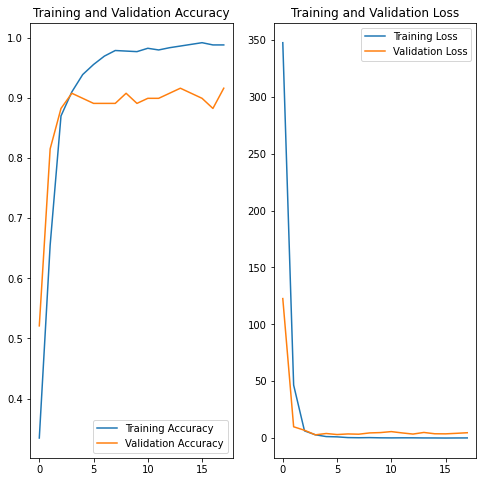

In [11]:
# visualize training results by plotting accuracy and loss on training and validation sets
# accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# loss
loss = history.history['loss']
val_loss = history.history['val_loss']
# plot for each epoch
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# save model
model.save("/content/drive/MyDrive/image_classifier/")
print("Model is saved.")

Model is saved.
